In [ ]:
import sys
import os
if 'google.colab' in sys.modules:
    # Google Drive
    from google.colab import drive
    drive.mount("/content/drive")
    %cd /content/drive/MyDrive/colab_notebooks/kaggle/Kaggle-Coleridge-Initiative/notebooks
    
    # Config File
    import yaml
    from pprint import pprint
    with open('../config/config.yml') as file:
        CFG = yaml.load(file)
    pprint(CFG)
    
    # Kaggle API
    !pip install --upgrade --force-reinstall --no-deps kaggle
    import json
    f = open("/content/drive/MyDrive/colab_notebooks/kaggle/kaggle.json", "r")
    json_data = json.load(f)
    os.environ["KAGGLE_USERNAME"] = json_data["username"]
    os.environ["KAGGLE_KEY"] = json_data["key"]
    
    # Download Kaggle Dataset
    dname = "kagglenb006-get-text"
    !mkdir ../input/{dname}
    !kaggle kernels output riow1983/{dname} -p ../input/{dname}
    
    # Output File Location
    dname = "localnb002-bilstm-ner"
    os.makedirs(dname, exist_ok=True)
    
    # GPU
    !nvidia-smi

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/colab_notebooks/kaggle/Kaggle-Coleridge-Initiative/notebooks
{'cv_debug': False,
 'debug': True,
 'embedding_dim': 100,
 'epochs': 10,
 'is_single': False,
 'learning_rate': 2e-05,
 'max_len': 128,
 'tags_vals': 'o o-dataset pad',
 'test_batch_size': 64,
 'text_len': 15000,
 'train': True,
 'train_batch_size': 32,
 'unique_key': 'pub_title',
 'use_cosine': True,
 'use_pos': False,
 'valid_batch_size': 64}
Processing /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303/kaggle-1.5.12-cp37-none-any.whl
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
mkdir: cannot create directory ‘../input/kagglenb006-get-text’: File exists
Output file downloaded to ../input/kagglenb006-get-text/folds_pubcat.pkl
Kernel log downloaded to ../input/kagglen

In [ ]:
if 'google.colab' in sys.modules:
    %cd /content/drive/MyDrive/colab_notebooks/kaggle/Kaggle-Coleridge-Initiative/input
    folder = "embeddings"
    if not os.path.exists(f"./{folder}/glove.6B.100d.txt"):
        os.makedirs(folder, exist_ok=True)
        
        print("Starting to download the embedding file...")
        !wget http://nlp.stanford.edu/data/glove.6B.zip -P {folder}
        print("...Done")

        print("Starting to unzip the downloaded file...")
        !unzip {folder}/glove.6B.zip -d {folder}
        !rm {folder}/glove.6B.zip
        print("...Done")

    # back to the original directory
    %cd /content/drive/MyDrive/colab_notebooks/kaggle/Kaggle-Coleridge-Initiative/notebooks

/content/drive/MyDrive/colab_notebooks/kaggle/Kaggle-Coleridge-Initiative/input
/content/drive/MyDrive/colab_notebooks/kaggle/Kaggle-Coleridge-Initiative/notebooks


In [ ]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf 
print("tf.__version__: ", tf.__version__)
from tensorflow.keras import layers
from fastprogress.fastprogress import master_bar, progress_bar

try:
    from seqeval.metrics import classification_report
except ModuleNotFoundError:
    !pip install seqeval
    from seqeval.metrics import classification_report

from tqdm.notebook import tqdm
import pickle
import gc

tf.__version__:  2.5.0


In [ ]:
MAX_LEN = CFG["max_len"] #max_seq_len = args.max_seq_len
EMBEDDING_DIM = CFG["embedding_dim"] #EMBEDDING_DIM = args.embedding_dim
TRAIN_BATCH_SIZE = CFG["train_batch_size"] #train_batch_size = args.train_batch_size
VALID_BATCH_SIZE = CFG["valid_batch_size"] #valid_batch_size = args.valid_batch_size
TEST_BATCH_SIZE = CFG["test_batch_size"] #test_batch_size = args.test_batch_size
EPOCHS = CFG["epochs"] #epochs = args.epochs
LEARNING_RATE = CFG["learning_rate"]
TRAIN = CFG["train"]
USE_POS = CFG["use_pos"]
DEBUG = CFG["debug"]
TEXT_LEN = CFG["text_len"]
TAGS_VALS = CFG["tags_vals"]

In [ ]:
if TRAIN:
    for fold in range(5):
        !python ../src/bridge_localnb002.py {fold+1} {TRAIN} {MAX_LEN} {USE_POS} {DEBUG} {TEXT_LEN} {TAGS_VALS}

else:
    fold=None
    !python ../src/bridge_localnb002.py {fold} {TRAIN} {MAX_LEN} {USE_POS} {DEBUG} {TEXT_LEN} {TAGS_VALS}

In [ ]:
# def split_text_label(filename):
#     f = open(filename)
#     split_labeled_text = []
#     sentence = []
#     for line in f:
#         if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
#             if len(sentence) > 0:
#                 split_labeled_text.append(sentence)
#                 sentence = []
#             continue
#         splits = line.split(' ')
#         sentence.append([splits[0],splits[-1].rstrip("\n")])
    
#     if len(sentence) > 0:
#         split_labeled_text.append(sentence)
#         sentence = []
#     return split_labeled_text

In [ ]:
"""
  [[['EU', 'B-ORG'],
    ['rejects', 'O'],
    ['German', 'B-MISC'],
    ['call', 'O'],
    ['to', 'O'],
    ['boycott', 'O'],
    ['British', 'B-MISC'],
    ['lamb', 'O'],
    ['.', 'O']],
    [['Peter', 'B-PER'], 
    ['Blackburn', 'I-PER']],
    [['BRUSSELS', 'B-LOC'], 
    ['1996-08-22', 'O']]]
"""

In [ ]:
def get_text_label(filename):
    """
    Args:
        filename: str
    Returns:
        labeled_text: List[List[str]]
    """
    f = open(filename)
    labeled_text = []
    sentence = []
    num_current_hash = 0
    for line in f:
        splits = line.split(' ')
        if "test" not in filename.split("_"):
            ''' splits: [word, tag, hash#, sentence] '''
            while splits[2] == f"sentence#{num_current_hash}":
                sentence.append([splits[0], splits[1], splits[2], splits[3].rstrip("\n")])
            else:
                if len(sentence) > 0:
                    labeled_text.append(sentence)
                    sentence = []
                    num_current_hash += 1

        else:
            ''' splits: [word, hash#, sentence] '''
            while splits[2] == f"sentence#{num_current_hash}":
                sentence.append([splits[0], splits[1], splits[2].rstrip("\n")])
            else:
                if len(sentence) > 0:
                    labeled_text.append(sentence)
                    sentence = []
                    num_current_hash += 1
    return labeled_text

In [ ]:
split_train = get_text_label("./list_train_fold_1.txt")
#split_valid = get_text_label("./list_valid_fold_1.txt")

In [ ]:
print("split_train:\n", split_train[:2])
"""
pos_idx = np.where(np.array(list_train_fold[1])=="sentence0")[0]
print(f"from {pos_idx.min()} to {pos_idx.max()}")
list_sentences = list_train_fold[0][pos_idx.min():pos_idx.max()+1]
for i,list_sentence in enumerate(list_sentences):
    print(i+pos_idx.min(), len(list_sentence))
"""

In [ ]:
del split_train
gc.collect()

In [ ]:
folds = pd.read_pickle("./dataset.pkl")
folds

,pub_title,cleaned_label,dataset_label,dataset_title,Id,pub_category,fold,text,word,pos,sentence,sentence#,tag
0,"Physical distancing, face masks, and eye prote...",covid 19 open research dataset,[COVID-19 Open Research Dataset],[COVID-19 Open Research Dataset (CORD-19)],a70a28bd-78e9-432e-aadc-7f7280dab0ee,covid 19 genome sequences + covid 19 open rese...,3,as of may 28 2020 severe acute respiratory syn...,"[as, of, may, 28, 2020, severe, acute, respira...",None,sentence13848,"[sentence#0, sentence#0, sentence#0, sentence#...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Adaption to Climate Change through Fallow Rota...,census of agriculture,[Census of Agriculture],[Census of Agriculture],c11b76ee-808a-4c9d-93b3-70a2f5478e89,agricultural resources management survey + arm...,1,in this paper we study the use of wheat land f...,"[in, this, paper, we, study, the, use, of, whe...",None,sentence1496,"[sentence#0, sentence#0, sentence#0, sentence#...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,The Impact of Repealing Sunday Closing Laws on...,national education longitudinal study,[National Education Longitudinal Study],[National Education Longitudinal Study],e03d3c0f-66b1-4767-82f0-b91c55b88f89,agricultural resources management survey + arm...,1,economists and policymakers have devoted consi...,"[economists, and, policymakers, have, devoted,...",None,sentence6879,"[sentence#0, sentence#0, sentence#0, sentence#...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Cohort Profile: The Healthy Aging Longitudinal...,baltimore longitudinal study of aging,[Baltimore Longitudinal Study of Aging],[Baltimore Longitudinal Study of Aging (BLSA)],3f812cc5-7bd4-4ef2-a532-c3bfa22bbec5,alzheimers disease neuroimaging initiative + b...,2,that effective prevention programmes can be de...,"[that, effective, prevention, programmes, can,...",None,sentence9349,"[sentence#0, sentence#0, sentence#0, sentence#...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Agricultural Finance Markets in Transition: A...,agricultural resource management survey,[Agricultural Resource Management Survey],[Agricultural Resource Management Survey],bbf6b4c4-018a-4696-8890-442ac0ddc628,agricultural resources management survey + arm...,1,1 charles b dodson and steven r koenig are agr...,"[1, charles, b, dodson, and, steven, r, koenig...",None,sentence7942,"[sentence#0, sentence#0, sentence#0, sentence#...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,OLD FARMER PENSION PROGRAM AND FARM SUCCESSION...,agricultural resource management survey,[Agricultural Resource Management Survey],[Agricultural Resource Management Survey],74885b9a-f50e-4f87-97dc-7e63621851f3,agricultural resources management survey + arm...,1,in most european and east asian countries the ...,"[in, most, european, and, east, asian, countri...",None,sentence5071,"[sentence#0, sentence#0, sentence#0, sentence#...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
496,Independent information from cerebrospinal flu...,adni,[ADNI],[Alzheimer's Disease Neuroimaging Initiative (...,71f6cb74-de79-4cdf-bd10-f1e78c9942bc,alzheimers disease neuroimaging initiative + b...,2,for a scientific commentary on this article re...,"[for, a, scientific, commentary, on, this, art...",None,sentence10644,"[sentence#0, sentence#0, sentence#0, sentence#...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
497,THE APPLICATION OF NASA EARTH OBSERVATION SYST...,slosh model,[SLOSH model],"[Sea, Lake, and Overland Surges from Hurricanes]",355c4dad-ace5-42dd-8afc-7b2b59670ec5,agricultural resources management survey + arm...,1,climate change and the resulting rise in sea l...,"[climate, change, and, the, resulting, rise, i...",None,sentence6492,"[sentence#0, sentence#0, sentence#0, sentence#...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
498,Migration patterns of San Francisco Bay Area H...,north american breeding bird survey,[North 

In [ ]:
len(folds.loc[0, "word"])

5558

In [ ]:
len(folds.loc[0, "tag"])

5558

In [ ]:
np.where(np.array(folds.loc[0, "sentence#"])=="sentence#0")[0]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127])

In [ ]:
# class Args:
#     use_tf = True
#     data = "../input/conll003-englishversion"
#     max_seq_len = 128
    
#     train_batch_size = 32
#     valid_batch_size = 64
#     test_batch_size = 64

#     embedding_dim = 100
#     epochs = 10
#     output = "nb011-ner-conll"
    
# args = Args()

# max_seq_len = args.max_seq_len
# EMBEDDING_DIM = args.embedding_dim
# train_batch_size = args.train_batch_size
# valid_batch_size = args.valid_batch_size
# test_batch_size = args.test_batch_size
# epochs = args.epochs

***
# Preprocessing

In [ ]:
# def split_text_label(filename):
#     f = open(filename)
#     split_labeled_text = []
#     sentence = []
#     for line in f:
#         if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
#             if len(sentence) > 0:
#                 split_labeled_text.append(sentence)
#                 sentence = []
#             continue
#         splits = line.split(' ')
#         sentence.append([splits[0],splits[-1].rstrip("\n")])
    
#     if len(sentence) > 0:
#         split_labeled_text.append(sentence)
#         sentence = []
#     return split_labeled_text

In [ ]:
# folds -> split_train, split_valid
folds[["word", "tag", "sentence#", "fold"]]

,word,tag,sentence#,fold
0,"[as, of, may, 28, 2020, severe, acute, respira...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[sentence#0, sentence#0, sentence#0, sentence#...",3
1,"[in, this, paper, we, study, the, use, of, whe...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[sentence#0, sentence#0, sentence#0, sentence#...",1
2,"[economists, and, policymakers, have, devoted,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[sentence#0, sentence#0, sentence#0, sentence#...",1
3,"[that, effective, prevention, programmes, can,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[sentence#0, sentence#0, sentence#0, sentence#...",2
4,"[1, charles, b, dodson, and, steven, r, koenig...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[sentence#0, sentence#0, sentence#0, sentence#...",1
...,...,...,...,...
495,"[in, most, european, and, east, asian, countri...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[sentence#0, sentence#0, sentence#0, sentence#...",1
496,"[for, a, scientific, commentary, on, this, art...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[sentence#0, sentence#0, sentence#0, sentence#...",2
497,"[climate, change, and, the, resulting, rise, i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[sentence#0, sentence#0, sentence#0, sentence#...",1
498,"[abstract, effective, conservation, of, short,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[sentence#0, sentence#0, sentence#0, sentence#...",1


In [ ]:
def ner_zipper(words, tags, segments):
    """
    Args:
        words: np.array[str]
        tags: np.array[int]
        segments: np.array[str]
    Returns:
        all_zipped: List[List[List[str]]]

    Examples:
        all_zipped[:3]:
            [[['EU', 'B-ORG'],
              ['rejects', 'O'],
              ['German', 'B-MISC'],
              ['call', 'O'],
              ['to', 'O'],
              ['boycott', 'O'],
              ['British', 'B-MISC'],
              ['lamb', 'O'],
              ['.', 'O']],
             [['Peter', 'B-PER'], 
              ['Blackburn', 'I-PER']],
             [['BRUSSELS', 'B-LOC'], 
              ['1996-08-22', 'O']]]
    """
    index2tag = {0:"o", 1:"o-dataset", 2:"pad"}
    f = lambda x: index2tag.get(x)
    f = np.vectorize(f)
    tags = f(tags)

    all_zipped = []
    for current_segment in np.unique(segments):
        pos_idx = np.where(segments==current_segment)[0]
        zipped = [[word, tag] for word, tag in zip(words[pos_idx], tags[pos_idx])]
        all_zipped.append(zipped)

    return all_zipped

In [ ]:
cv = 1
split_train = []
split_valid = []

for i,row in tqdm(folds[folds["fold"]!=1].iterrows()):
    all_zipped_per_text = ner_zipper(np.array(row["word"]), 
                                     np.array(row["tag"]), 
                                     np.array(row["sentence#"]))
    split_train.extend(all_zipped_per_text)


for i,row in tqdm(folds[folds["fold"]==1].iterrows()):
    all_zipped_per_text = ner_zipper(np.array(row["word"]), 
                                     np.array(row["tag"]), 
                                     np.array(row["sentence#"]))
    split_valid.extend(all_zipped_per_text)

In [ ]:
#split_train[:3]

In [ ]:
#split_valid[-3:]

In [ ]:
# split_train = split_text_label(os.path.join(args.data, "train.txt"))
# split_valid = split_text_label(os.path.join(args.data, "valid.txt"))
# split_test = split_text_label(os.path.join(args.data, "test.txt"))

In [ ]:
split_train[:3]

[[['EU', 'B-ORG'],
  ['rejects', 'O'],
  ['German', 'B-MISC'],
  ['call', 'O'],
  ['to', 'O'],
  ['boycott', 'O'],
  ['British', 'B-MISC'],
  ['lamb', 'O'],
  ['.', 'O']],
 [['Peter', 'B-PER'], ['Blackburn', 'I-PER']],
 [['BRUSSELS', 'B-LOC'], ['1996-08-22', 'O']]]

In [ ]:
split_valid[:3]

[[['CRICKET', 'O'],
  ['-', 'O'],
  ['LEICESTERSHIRE', 'B-ORG'],
  ['TAKE', 'O'],
  ['OVER', 'O'],
  ['AT', 'O'],
  ['TOP', 'O'],
  ['AFTER', 'O'],
  ['INNINGS', 'O'],
  ['VICTORY', 'O'],
  ['.', 'O']],
 [['LONDON', 'B-LOC'], ['1996-08-30', 'O']],
 [['West', 'B-MISC'],
  ['Indian', 'I-MISC'],
  ['all-rounder', 'O'],
  ['Phil', 'B-PER'],
  ['Simmons', 'I-PER'],
  ['took', 'O'],
  ['four', 'O'],
  ['for', 'O'],
  ['38', 'O'],
  ['on', 'O'],
  ['Friday', 'O'],
  ['as', 'O'],
  ['Leicestershire', 'B-ORG'],
  ['beat', 'O'],
  ['Somerset', 'B-ORG'],
  ['by', 'O'],
  ['an', 'O'],
  ['innings', 'O'],
  ['and', 'O'],
  ['39', 'O'],
  ['runs', 'O'],
  ['in', 'O'],
  ['two', 'O'],
  ['days', 'O'],
  ['to', 'O'],
  ['take', 'O'],
  ['over', 'O'],
  ['at', 'O'],
  ['the', 'O'],
  ['head', 'O'],
  ['of', 'O'],
  ['the', 'O'],
  ['county', 'O'],
  ['championship', 'O'],
  ['.', 'O']]]

In [ ]:
split_test[:3]

[[['SOCCER', 'O'],
  ['-', 'O'],
  ['JAPAN', 'B-LOC'],
  ['GET', 'O'],
  ['LUCKY', 'O'],
  ['WIN', 'O'],
  [',', 'O'],
  ['CHINA', 'B-PER'],
  ['IN', 'O'],
  ['SURPRISE', 'O'],
  ['DEFEAT', 'O'],
  ['.', 'O']],
 [['Nadim', 'B-PER'], ['Ladki', 'I-PER']],
 [['AL-AIN', 'B-LOC'],
  [',', 'O'],
  ['United', 'B-LOC'],
  ['Arab', 'I-LOC'],
  ['Emirates', 'I-LOC'],
  ['1996-12-06', 'O']]]

In [ ]:
for data in [split_train, split_valid]:
    print(data)

[[['as', 'o'], ['of', 'o'], ['may', 'o'], ['28', 'o'], ['2020', 'o'], ['severe', 'o'], ['acute', 'o'], ['respiratory', 'o'], ['syndrome', 'o'], ['coronavirus', 'o'], ['2', 'o'], ['sars', 'o'], ['cov', 'o'], ['2', 'o'], ['has', 'o'], ['infected', 'o'], ['more', 'o'], ['than', 'o'], ['5', 'o'], ['85', 'o'], ['million', 'o'], ['individuals', 'o'], ['worldwide', 'o'], ['and', 'o'], ['caused', 'o'], ['more', 'o'], ['than', 'o'], ['359', 'o'], ['000', 'o'], ['deaths', 'o'], ['1', 'o'], ['emergency', 'o'], ['lockdowns', 'o'], ['have', 'o'], ['been', 'o'], ['initiated', 'o'], ['in', 'o'], ['countries', 'o'], ['across', 'o'], ['the', 'o'], ['globe', 'o'], ['and', 'o'], ['the', 'o'], ['effect', 'o'], ['on', 'o'], ['health', 'o'], ['wellbeing', 'o'], ['business', 'o'], ['and', 'o'], ['other', 'o'], ['aspects', 'o'], ['of', 'o'], ['daily', 'o'], ['life', 'o'], ['are', 'o'], ['felt', 'o'], ['throughout', 'o'], ['societies', 'o'], ['and', 'o'], ['by', 'o'], ['individuals', 'o'], ['with', 'o'], ['no'

In [ ]:
labelSet = set()
wordSet = set()
# words and labels
#for data in [split_train, split_valid, split_test]:
for data in [split_train, split_valid]:
    for labeled_text in data:
        for word, label in labeled_text:
            labelSet.add(label)
            wordSet.add(word.lower())

In [ ]:
if DEBUG:
    labelSet = {"o", "o-dataset", "pad"}
print(labelSet)
#print(wordSet)

{'o-dataset', 'o', 'pad'}


In [ ]:
# Sort the set to ensure '0' is assigned to 0
#sorted_labels = sorted(list(labelSet), key=len)
sorted_labels = ["o", "o-dataset", "pad"]

# Create mapping for labels
label2Idx = {}
for label in sorted_labels:
    label2Idx[label] = len(label2Idx)
num_labels = len(label2Idx)
idx2Label = {v: k for k, v in label2Idx.items()}



# Create mapping for words
word2Idx = {}
if len(word2Idx) == 0:
    word2Idx["PADDING_TOKEN"] = len(word2Idx)
    word2Idx["UNKNOWN_TOKEN"] = len(word2Idx)
for word in wordSet:
    word2Idx[word] = len(word2Idx)

In [ ]:
def createMatrices(data, word2Idx, label2Idx):
    sentences = []
    labels = []
    for split_labeled_text in data:
        wordIndices = []
        labelIndices = []
        for word, label in split_labeled_text:
            if word in word2Idx:
                wordIdx = word2Idx[word]
            elif word.lower() in word2Idx:
                wordIdx = word2Idx[word.lower()]
            else:
                wordIdx = word2Idx['UNKNOWN_TOKEN']
            wordIndices.append(wordIdx)
            labelIndices.append(label2Idx[label])
        sentences.append(wordIndices)
        labels.append(labelIndices)
    return sentences, labels

In [ ]:
train_sentences, train_labels = createMatrices(split_train, word2Idx, label2Idx)
valid_sentences, valid_labels = createMatrices(split_valid, word2Idx, label2Idx)
#test_sentences, test_labels = createMatrices(split_test, word2Idx, label2Idx)

In [ ]:
train_sentences[:3]

In [ ]:
train_sentences[:3]

[[13371, 12166, 1387, 5658, 10976, 7498, 7314, 23965, 7735],
 [10319, 17638],
 [23230, 5102]]

In [ ]:
train_labels[:3]

In [ ]:
train_labels[:3]

[[5, 0, 7, 0, 0, 0, 7, 0, 0], [4, 3], [2, 0]]

max length: 128 
min length: 1


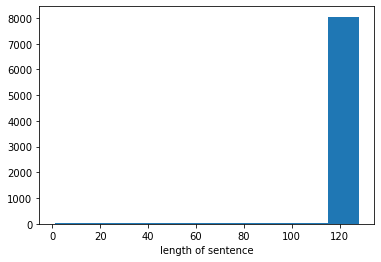

In [ ]:
tmp = [len(sentence) for sentence in train_sentences]
print(f"max length: {np.max(tmp)} \nmin length: {np.min(tmp)}")
plt.hist(tmp)
plt.xlabel('length of sentence');

max length: 113 
min length: 1


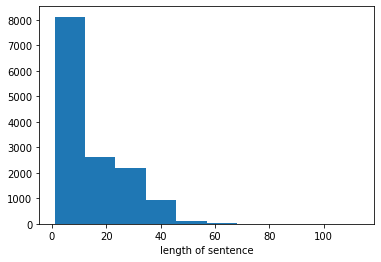

In [ ]:
tmp = [len(sentence) for sentence in train_sentences]
print(f"max length: {np.max(tmp)} \nmin length: {np.min(tmp)}")
plt.hist(tmp)
plt.xlabel('length of sentence');

In [ ]:
def padding(sentences, labels, max_len, padding='post'):
    padded_sentences = pad_sequences(sentences, max_len, padding='post')
    padded_labels = pad_sequences(labels, max_len, padding='post')
    return padded_sentences, padded_labels

In [ ]:
train_features, train_labels = padding(train_sentences, train_labels, MAX_LEN, padding='post')
valid_features, valid_labels = padding(valid_sentences, valid_labels, MAX_LEN, padding='post')
#test_features, test_labels = padding(test_sentences, test_labels, MAX_LEN, padding='post')

In [ ]:
train_features

array([[ 4594, 13885, 35178, ..., 18068, 54885, 48829],
       [ 8951, 21091,  6293, ..., 13885,   833,  1649],
       [12131, 16037, 58941, ..., 42181, 56644, 26804],
       ...,
       [58432, 23970, 13885, ..., 21962, 20809, 20912],
       [ 4389, 18968, 48449, ..., 54429, 50771, 53554],
       [16377, 33355, 55994, ..., 50771, 21962,  6033]], dtype=int32)

In [ ]:
train_features

array([[13371, 12166,  1387, ...,     0,     0,     0],
       [10319, 17638,     0, ...,     0,     0,     0],
       [23230,  5102,     0, ...,     0,     0,     0],
       ...,
       [22061,  2417, 26266, ...,     0,     0,     0],
       [22076, 18370,     0, ...,     0,     0,     0],
       [18735,  1038,   733, ...,     0,     0,     0]], dtype=int32)

In [ ]:
train_features.shape

(8241, 128)

In [ ]:
train_features.shape

(14041, 128)

In [ ]:
train_labels.shape

(8241, 128)

In [ ]:
train_labels.shape

(14041, 128)

In [ ]:
# Loading glove embeddings
embeddings_index = {}
f = open('../input/embeddings/glove.6B.100d.txt', encoding="utf-8")
for line in f:
    values = line.strip().split(' ')
    word = values[0] # the first entry is the word
    coefs = np.asarray(values[1:], dtype='float32') #100d vectors representing the word
    embeddings_index[word] = coefs
f.close()
embedding_matrix = np.zeros((len(word2Idx), EMBEDDING_DIM))

In [ ]:
# Word embeddings for the tokens
for word,i in word2Idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(61619, 100)

In [ ]:
word = "PADDING_TOKEN"
i = word2Idx.get(word)
print(i)
embedding_matrix[i]

0


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
word = "UNKNOWN_TOKEN"
i = word2Idx.get(word)
print(i)
embedding_matrix[i]

1


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
embedding_matrix.shape

(61619, 100)

In [ ]:
embedding_matrix.shape

(26871, 100)

***
# Train

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_features, valid_labels))
#test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels))

In [ ]:
shuffled_train_dataset = train_dataset.shuffle(buffer_size=train_features.shape[0], reshuffle_each_iteration=True)
batched_train_dataset = shuffled_train_dataset.batch(TRAIN_BATCH_SIZE, drop_remainder=True)
batched_valid_dataset = valid_dataset.batch(VALID_BATCH_SIZE, drop_remainder=True)
#batched_test_dataset = test_dataset.batch(TEST_BATCH_SIZE, drop_remainder=True)

In [ ]:
class TFNer(tf.keras.Model):
    def __init__(self, max_seq_len, embed_input_dim, embed_output_dim, num_labels, weights):
        super(TFNer, self).__init__() 
        self.embedding = layers.Embedding(input_dim=embed_input_dim, 
                                          output_dim=embed_output_dim, 
                                          weights=weights,   
                                          input_length=max_seq_len,
                                          trainable=False, 
                                          mask_zero=True)        

        self.bilstm = layers.Bidirectional(layers.LSTM(max_seq_len, return_sequences=True))
        self.dense = layers.Dense(num_labels)
    
    def call(self, inputs):
        x = self.embedding(inputs) # batchsize, max_seq_len, embedding_output_dim
        x = self.bilstm(x) #batchsize, max_seq_len, hidden_dim_bilstm
        logits = self.dense(x) #batchsize, max_seq_len, num_labels
        return logits

In [ ]:
model = TFNer(max_seq_len=MAX_LEN,
              embed_input_dim=len(word2Idx),
              embed_output_dim=EMBEDDING_DIM,
              weights=[embedding_matrix], 
              num_labels=num_labels)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [ ]:
scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
train_loss_metric = tf.keras.metrics.Mean('training_loss', dtype=tf.float32)
valid_loss_metric = tf.keras.metrics.Mean('valid_loss', dtype=tf.float32)

In [ ]:
def train_step_fn(sentences_batch, labels_batch):
    with tf.GradientTape() as tape:
        logits = model(sentences_batch)
        loss = scce(labels_batch, logits)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(list(zip(grads, model.trainable_variables)))
    return loss, logits

def valid_step_fn(sentences_batch, labels_batch):
    logits = model(sentences_batch)
    loss = scce(labels_batch, logits)
    return loss, logits

In [ ]:
epoch_bar = master_bar(range(EPOCHS))
train_pb_max_len = math.ceil(float(len(train_features))/float(TRAIN_BATCH_SIZE))
valid_pb_max_len = math.ceil(float(len(valid_features))/float(VALID_BATCH_SIZE))
#test_pb_max_len = math.ceil(float(len(test_features))/float(test_batch_size))

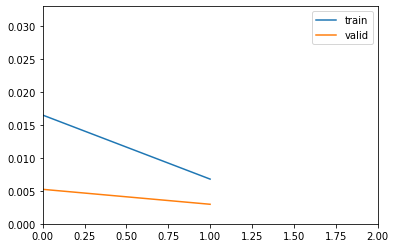

In [ ]:
# 学習曲線描画のための前準備
train_losses_epoch = []
valid_losses_epoch = []
x_bounds = [0, EPOCHS]
y_bounds = None
y_upper_bound = None
for epoch in epoch_bar:
    
    train_losses = []
    for sentences_batch, labels_batch in progress_bar(batched_train_dataset, total=train_pb_max_len, parent=epoch_bar):
        loss, logits = train_step_fn(sentences_batch, labels_batch)
        train_losses.append(loss)
        train_loss_metric(loss)
    train_loss_metric.reset_states()
    
    valid_losses = []
    for sentences_batch, labels_batch in progress_bar(batched_valid_dataset, total=valid_pb_max_len, parent=epoch_bar):
        loss, logits = valid_step_fn(sentences_batch, labels_batch)
        valid_losses.append(loss)
        valid_loss_metric.update_state(loss)
    valid_loss_metric.reset_states()


    train_loss_mean = np.mean(train_losses)
    valid_loss_mean = np.mean(valid_losses)
    train_losses_epoch.append(train_loss_mean)
    valid_losses_epoch.append(valid_loss_mean)


    # learning curveの図示
    if y_bounds is None:
        # 1エポック目のみ実行
        y_bounds = [0, train_loss_mean*2 if y_upper_bound is None else y_upper_bound]

    t = np.arange(len(train_losses_epoch))
    graphs = [[t, train_losses_epoch], [t, valid_losses_epoch]]
    epoch_bar.update_graph(graphs, x_bounds, y_bounds)

    # 学習過程の出力
    epoch_bar.write(f'EPOCH: {epoch+1:02d}, Training loss: {train_loss_mean:10.5f}, Validation loss: {valid_loss_mean:10.5f}')

In [ ]:
if DEBUG:
    model.save_weights(f"./{dname}/debug_model_weights", save_format='tf')
else:
    model.save_weights(f"./{dname}/model_weights", save_format='tf')

***
# Inference

In [ ]:
if 'google.colab' in sys.modules:
    batched_test_dataset = batched_valid_dataset
    test_pb_max_len = valid_pb_max_len

In [ ]:
def idx_to_label(predictions, correct, idx2Label):
    
    label_pred = []
    for sentence in predictions:
        for i in sentence:
            label_pred.append([idx2Label[elem] for elem in i])
    
    label_correct = []
    if correct != None:
        for sentence in correct:
            for i in sentence:
                label_correct.append([idx2Label[elem] for elem in i])
    
    return label_correct, label_pred

In [ ]:
test_model =  TFNer(max_seq_len=MAX_LEN, 
                    embed_input_dim=len(word2Idx), 
                    embed_output_dim=EMBEDDING_DIM, 
                    weights=[embedding_matrix], 
                    num_labels=num_labels)
if DEBUG:
    test_model.load_weights(f"{dname}/debug_model_weights")
else:
    test_model.load_weights(f"{dname}/model_weights")

In [ ]:
from seqeval.metrics import f1_score

# def flat_accuracy(preds, labels):
#     flat_preds = np.argmax(preds, axis=2).flatten()
#     flat_labels = labels.flatten()
#     return np.sum(flat_preds == flat_labels)/len(flat_labels)

In [ ]:
true_labels = []
pred_labels = []
for sentences_batch, labels_batch in progress_bar(batched_test_dataset, total=test_pb_max_len):
    logits = test_model(sentences_batch)
    temp1 = tf.nn.softmax(logits)
    preds = tf.argmax(temp1, axis=2)
    true_labels.append(np.asarray(labels_batch))
    pred_labels.append(np.asarray(preds))

label_correct, label_pred = idx_to_label(pred_labels, true_labels, idx2Label)
#report = classification_report(label_correct, label_pred, digits=4)
#print(report)

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: o seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


0.0


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:160: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, 'true nor predicted', 'F-score is', len(true_sum)


In [ ]:
score = f1_score(label_correct, label_pred, zero_division=0)
print(f"f1 score: {score}")

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: o seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


f1 score: 0.0


In [ ]:
# true_labels = []
# pred_labels = []
# for sentences_batch, labels_batch in progress_bar(batched_test_dataset, total=test_pb_max_len):
#     logits = test_model(sentences_batch)
#     temp1 = tf.nn.softmax(logits)
#     preds = tf.argmax(temp1, axis=2)
#     true_labels.append(np.asarray(labels_batch))
#     pred_labels.append(np.asarray(preds))

# label_correct, label_pred = idx_to_label(pred_labels, true_labels, idx2Label)
# report = classification_report(label_correct, label_pred, digits=4)
# print(report)

              precision    recall  f1-score   support

         LOC     0.0037    0.0030    0.0033      1651
        MISC     0.6667    0.6745    0.6706       682
         ORG     0.0219    0.0311    0.0257      1610
         PER     0.1381    0.2738    0.1836      1596

   micro avg     0.1269    0.1719    0.1460      5539
   macro avg     0.2076    0.2456    0.2208      5539
weighted avg     0.1293    0.1719    0.1439      5539

